In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
from itertools import product
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import chi2

In [2]:
df = pd.read_excel("../../data/raw/PSP_Jan_Feb_2019.xlsx", index_col=0)

## Datenqualität
### Duplikate entfernen und Spaltentypen konvertieren

In [3]:
# Alle exakten Duplikate entfernen
df.drop_duplicates(inplace=True)

In [4]:
# Prüfen, ob die Änderungen übernommen wurden
df[df.duplicated()]

,tmsp,country,amount,success,PSP,3D_secured,card


## Feature Engineering

### Mögliche Zusatzvariablen:
 - Anzahl vorheriger fehlgeschlagener Fehlversuche
 - Anzahl Versuche Gesamt

In [5]:
# Sortieren des DataFrame nach Land, amount und tmsp 
df_copy=df.sort_values(by=["country","amount","tmsp"]).reset_index().drop("index",axis=1)
# Erstellen einer Bedingung, die erkennt, wenn eine Überweisung bereits schon einmal zuvor durchgeführt wurde
condition = ((df_copy["amount"]==df_copy["amount"].shift(1))
               & (df_copy["country"]==df_copy["country"].shift(1))
               &  ((df_copy["tmsp"]-df_copy["tmsp"].shift(1))<timedelta(minutes=1)))
# Anwenden der Bedingung auf den gesamten Datensatz
df_copy['i'] = np.where(condition,1,0)

In [6]:
def count_on_off(series):
    # Zähler initialisieren
    counter = 0
    # Liste für die kumulative Summe erstellen
    cum_sum = []
    # Durch die Elemente der Eingabeserie iterieren
    for value in series:
        if value == 1:
            # Wenn 1 auftritt, erhöhe den Zähler
            counter += 1
        else:
            # Wenn 0 auftritt, setze den Zähler zurück
            counter = 0
        # Füge den aktuellen Zählerwert zur kumulativen Summenliste hinzu
        cum_sum.append(counter)
    # Gib die kumulative Summenliste als Pandas-Serie zurück
    return pd.Series(cum_sum, index=series.index)

# Neue Spalte hinzufügen, die die kumulative Zählung von 0 und 1 enthält
df_copy["previous_attempts"] = count_on_off(df_copy["i"])

# Neuen DataFrame erstellen, der nur die zu verwendenden Features enthält.
df_copy = df_copy[["tmsp", "country", "amount", "success", "PSP", "3D_secured", "card","previous_attempts"]]


In [7]:
# Prüfen der Ergebnisse
df_copy.previous_attempts.value_counts()

previous_attempts
0    27613
1    12266
2     5606
3     2579
4     1201
5      577
6      277
7      138
8       71
9        1
Name: count, dtype: int64

### Zeitstempel
 - Wochentag
 - Tageszeit

In [8]:
# Hinzufügen der Features für Stunde und Wochentag
df_copy["hour"] = df_copy.tmsp.dt.hour
df_copy["week_day"] = df_copy.tmsp.dt.weekday

#### One Hot Encoding

In [12]:
categorial_cols = ["PSP","country","card","hour","week_day"]
# One Hot Encoding der kategorischen Variablen und Löschen einer entstehenden Spalte 
one_hot_encoded = pd.get_dummies(df_copy, columns=categorial_cols, drop_first=True, dtype=int)

In [13]:
# Löschen des Zeitstempels, da die relevanten Informationen in Stunde und Wochentag enthalten sind.
one_hot_encoded.drop("tmsp", axis = 1, inplace=True)
# Speichern des bereinigten Datensatzes.
one_hot_encoded.to_csv("../../data/preprocessed/PSP_Jan_Feb_2019_preprocessed.csv", sep=";", index=False)

In [14]:
one_hot_encoded

,amount,success,3D_secured,previous_attempts,PSP_Moneycard,PSP_Simplecard,PSP_UK_Card,country_Germany,country_Switzerland,card_Master,...,hour_20,hour_21,hour_22,hour_23,week_day_1,week_day_2,week_day_3,week_day_4,week_day_5,week_day_6
0,6,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,6,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,6,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,6,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,6,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50324,499,0,0,2,0,0,1,0,1,1,...,0,0,0,0,0,0,1,0,0,0
50325,499,0,0,3,0,0,1,0,1,1,...,0,0,0,0,0,0,1,0,0,0
50326,499,0,0,4,0,0,1,0,1,1,...,0,0,0,0,0,0,1,0,0,0
50327,499,0,0,5,0,0,1,0,1,1,...,0,0,0,0,0,0,1,0,0,0


## Feature Selection General

In [15]:
# Nehme gespeicherten Datensatz mit allen Features als Basis
one_hot_copy = one_hot_encoded.copy()
# Entferne Zielfeature
target = one_hot_copy.pop("success")
# Durchführung Chi^2 Test des Feature Datensatzes auf die Zielvariable, um die Korrelation der Features mit der Zielvariable zu berechnen.
# H0 und H1 wie in Exploration.
chi2_stats, p_values = chi2(one_hot_copy, target)

In [16]:
# Speichern und sortieren der p-Werte 
p_values = pd.Series(p_values,index = one_hot_copy.columns)
p_values.sort_values(ascending = False , inplace = True)

hour_21           4.918946e-02
hour_12           4.342655e-02
hour_20           3.875237e-02
hour_13           1.877758e-02
hour_15           8.132152e-03
hour_14           5.545788e-03
hour_22           5.132655e-03
hour_18           1.491336e-03
PSP_UK_Card       7.369352e-04
week_day_1        5.087095e-04
PSP_Moneycard     4.110074e-04
hour_16           3.397225e-04
card_Master       1.487528e-04
hour_17           4.722319e-05
week_day_5        2.661018e-05
week_day_6        2.191658e-05
3D_secured        3.764129e-31
PSP_Simplecard    1.017109e-35
amount            0.000000e+00
dtype: float64


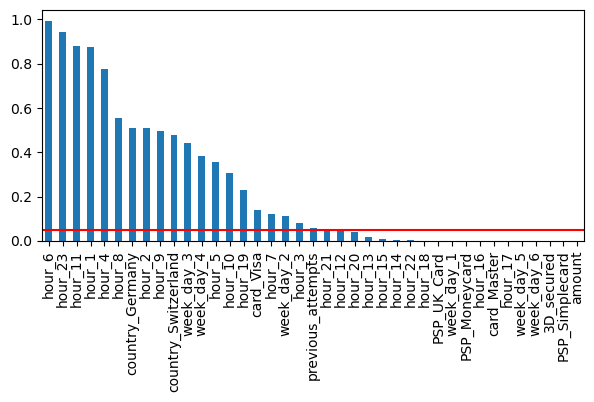

In [17]:
# Erstellen eines Plots, der die Signifikanz der Korrelation zwischen einem ausgewählten Feature und der Zielvariablen darstellt.
plt.figure(figsize=(7,3))
p_values.plot.bar();
# Einzeichnen einer Signifikanzgrenze bei 0,05
plt.axhline(y=0.05, color='r', linestyle='-');
plt.savefig("../../documentation/data-reports/feature_selection.pdf", format="pdf", bbox_inches="tight")
print(p_values[p_values<0.05])

### Erkenntnis:
 - Alles Features mit einem p-Wert über 0,05 werden aus dem Datensatz entfernt.

In [18]:
# Erstellen eines DataFrame, der nur die ausgewählten Features enthält und speichern dieses DataFrames
selected_features = list(p_values[p_values<0.05].index)
selected_features.append("success")
one_hot_encoded[selected_features].to_csv("../../data/preprocessed/PSP_Jan_Feb_2019_preprocessed_general_feature_selection.csv", sep=";", index=False)